In [1]:
import os
import sys
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 
import matplotlib
import torch.nn.functional as F
import imageio.v2 as imageio
from torch import nn
from tqdm import trange
from copy import deepcopy

%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES']="0"
    
def tonp(x):
    return x.cpu().detach().numpy()

def mse_fn(pred, gt):
    return ((pred - gt)**2).mean()

def psnr_fn(pred, gt):
    mse = mse_fn(pred.clip(0, 1), gt)
    if isinstance(pred, torch.Tensor):
        return -10 * torch.log10(mse)
    return -10 * np.log10(mse)

def psnr2mse(psnr):
    return 10**(-psnr/10)

def read_image(im_path):
    im = imageio.imread(im_path)
    im = np.array(im).astype(np.float32) / 255.
    return im

def write_image(im_path, im):
    im = (np.clip(im, 0, 1) * 255).astype(np.uint8)
    imageio.imwrite(im_path, im)

##### **Models**

In [2]:
import math
from torch.nn import init

def init_weights(m, omega=1, c=1, is_first=False): # Default: Pytorch initialization
    if hasattr(m, 'weight'):
        fan_in = m.weight.size(-1)
        if is_first:
            bound = 1 / fan_in # SIREN
        else:
            bound = math.sqrt(c / fan_in) / omega
        init.uniform_(m.weight, -bound, bound)
        
def init_weights_kaiming(m):
    if hasattr(m, 'weight'):
        init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')

def init_bias(m, k):
    if hasattr(m, 'bias'):
        init.uniform_(m.bias, -k, k)

def init_weights_cond(init_method, linear, omega=1, c=1, is_first=False):
    init_method = init_method.lower()
    if init_method == 'sine':
        init_weights(linear, omega, 6, is_first)    # SIREN initialization
    else: ## Default: Pytorch initialization
        pass

def init_bias_cond(linear, fbs=None, hbs=None, is_first=True):
    ''' TODO: bias initialization of hidden layers '''
    if is_first and fbs != None:
        init_bias(linear, fbs)
    if not is_first and hbs != None:        
        init_bias(linear, hbs)
    ## Default: Pytorch initialization

''' 
    FINER activation
    TODO: alphaType, alphaReqGrad
'''
def generate_alpha(x, alphaType=None, alphaReqGrad=False):
    if alphaReqGrad:
        # Default: abs_plus
        return torch.abs(x) + 1
    else:
        with torch.no_grad():
            # Default: abs_plus
            return torch.abs(x) + 1
    
def finer_activation(x, omega=1, alphaType=None, alphaReqGrad=False):
    return torch.sin(omega * generate_alpha(x, alphaType, alphaReqGrad) * x)





## FINER 
class FinerLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, omega=30, 
                 is_first=False, is_last=False, 
                 init_method='sine', init_gain=1, fbs=None, hbs=None, 
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.omega = omega
        self.is_last = is_last ## no activation
        self.alphaType = alphaType
        self.alphaReqGrad = alphaReqGrad
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        # init weights
        init_weights_cond(init_method, self.linear, omega, init_gain, is_first)
        # init bias
        init_bias_cond(self.linear, fbs, hbs, is_first)
    
    def forward(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            return finer_activation(wx_b, self.omega, self.alphaType, self.alphaReqGrad)
        return wx_b # is_last==True

    def forward_with_interm(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            alpha = generate_alpha(wx_b, self.alphaType, self.alphaReqGrad)
            return self.omega*wx_b, self.omega*alpha*wx_b, torch.sin(self.omega*alpha*wx_b)    
        return wx_b # is_last==True
      
class Finer(nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_layers=3, hidden_features=256, 
                 first_omega=30, hidden_omega=30, 
                 init_method='sine', init_gain=1, fbs=None, hbs=None, 
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.net = []
        self.net.append(FinerLayer(in_features, hidden_features, is_first=True, 
                                   omega=first_omega, 
                                   init_method=init_method, init_gain=init_gain, fbs=fbs,
                                   alphaType=alphaType, alphaReqGrad=alphaReqGrad))

        for i in range(hidden_layers):
            self.net.append(FinerLayer(hidden_features, hidden_features, 
                                       omega=hidden_omega, 
                                       init_method=init_method, init_gain=init_gain, hbs=hbs,
                                       alphaType=alphaType, alphaReqGrad=alphaReqGrad))

        self.net.append(FinerLayer(hidden_features, out_features, is_last=True, 
                                   omega=hidden_omega, 
                                   init_method=init_method, init_gain=init_gain, hbs=hbs)) # omega: For weight init
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        return self.net(coords)

    def forward_with_interm(self, input):
        interm = {}
        N = len(self.net)
        for idx, layer in enumerate(self.net):
            if idx != N-1:
                wxb, wxb_finer, sin_activated = layer.forward_with_interm(input)
                interm[f'layer_{idx}_wxb'] = wxb
                interm[f'layer_{idx}_wxb_finer'] = wxb_finer
                interm[f'layer_{idx}_sin_acted'] = sin_activated
                interm[f'layer_{idx}_out'] = sin_activated
                out = sin_activated
            else:
                out = layer(input)
                interm[f'layer_{idx}_out'] = out
            input = out
        return interm


## SIREN 
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)    
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        out = torch.sin(self.omega_0 * self.linear(input))
        return out

    def forward_with_interm(self, input):
        x = self.linear(input)
        interm = self.omega_0 * x
        out = torch.sin(interm)
        return out, x, interm    

class Siren(nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_layers=3, hidden_features=256, first_omega_0=30, hidden_omega_0=30):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))

        final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                          np.sqrt(6 / hidden_features) / hidden_omega_0)
        self.net.append(final_linear)

        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output
    
    def forward_with_interm(self, coords):
        ret_dict = {}
        input = coords
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                input, x, interm = layer.forward_with_interm(input)
                ret_dict[f'layer_{i}_out'] = input
                ret_dict[f'layer_{i}_liner_out'] = x
                ret_dict[f'layer_{i}_before_active'] = interm
            else: # output layer
                input = layer(input)
                ret_dict[f'layer_{i}_out'] = input
        return ret_dict


##### **Image Fitting** 

In [3]:
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret

# Image Fitting 
def train_image(model, coords, gt, loss_fn=mse_fn, lr=5e-4, num_epochs=2000, steps_til_summary=10, invnorm=lambda x:x, 
                is_batchify=False, batchsize=2**19):
    # 
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda iter: 0.1 ** min(iter / num_epochs, 1))
        
    train_iter = []
    train_psnr = []
    
    total_time = 0
    
    if not is_batchify:
        for epoch in trange(1, num_epochs + 1):
            time_start = time.time()
                    
            pred = model(coords)
            loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            torch.cuda.synchronize()
            total_time += time.time() - time_start
    
            if not epoch % steps_til_summary:
                with torch.no_grad():
                    train_iter.append(epoch)
                    train_psnr.append((psnr_fn(invnorm(model(coords)), invnorm(gt))).item())
    else:
        N = coords.shape[0]
        for epoch in trange(1, num_epochs + 1):
            time_start = time.time()
            
            idx = torch.randperm(N) # shuffle
            for i in range(0, N, batchsize):
                pred = model(coords[idx[i:i+batchsize]])
                loss = loss_fn(pred, gt[idx[i:i+batchsize]])
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
            
            torch.cuda.synchronize()
            total_time += time.time() - time_start
            
            if not epoch % steps_til_summary:
                with torch.no_grad():
                    train_iter.append(epoch)
                    pred = model(coords) if not is_batchify else batchify(model, batchsize)(coords)
                    train_psnr.append((psnr_fn(invnorm(pred), invnorm(gt))).item())
                
    with torch.no_grad():
        pred = model(coords) if not is_batchify else batchify(model, batchsize)(coords)
        pred = invnorm(pred)
        
    ret_dict = {
        'train_iter': train_iter,
        'train_psnr': train_psnr,
        'pred': pred,
        'model_state': model.state_dict(),
    }
    return ret_dict

In [4]:
from easydict import EasyDict

default_cfg = EasyDict({
    # Data
    'imgid':                0, 
    'datadir':              'data/div2k/test_data/',
    'specific_img':         None,
    
    # Model
    'model_type':           'Finer',        # Finer, SIREN
    'in_features':          2,
    'out_features':         3,
    'hidden_layers':        3,
    'hidden_features':      256,
    'first_omega':          30,             # sine
    'hidden_omega':         30,             # sine
    'fbs':                  None,
    'hbs':                  None,           
    'init_method':          'sine',         # sine, default: pytorch
    'alphaType':            'abs_plus',     # 
    'alphaReqGrad':         False,          # Default: False

    # Train
    'lr':                   5e-4,
    'num_epochs':           5000,
    'zero_mean':            True,
    'steps_til_summary':    10,
    'batchify':             False,
    'batchsize':            2**19,
    
    ## Log 
    'logdir':               'logs/Finer/',
    'savename':             'results',
    'reuse':                True,
    'exp_suffix':           '',
    
    ## Visualization
    'return_results':       False,
    'return_finalpsnr':     False,
    'show_image':           False,
    'print_expname':        True,
    'print_model':          False,
    'vis_result':           True,
    'vis_usefbs':           False,
    # first layer neurons visualization
    'vis_firstlayer_neuron':False,
    'cmap':                 'viridis', # 'viridis', 'coolwarm'
})

def imgid2path(imgid, datadir='data/div2k/test_data'):
    if datadir.find('div2k') != -1:
        path = os.path.join(datadir, '%02d.png'%(imgid))
    if datadir.find('kodak') != -1:
        path = os.path.join(datadir, 'kodim%02d.png'%(imgid))
    if datadir.find('DIV2K_train_HR') != -1:
        path = os.path.join(datadir, '%04d.png'%(imgid))
    return path

def activation_xy(cfg, a=-3, b=3):
    x = torch.linspace(a, b, 10000)
    if cfg.vis_usefbs and cfg.fbs: 
        x0 = x + cfg.fbs
    else:
        x0 = x
    mtype = cfg.model_type.lower()
    if mtype == 'finer':
        y = finer_activation(x0, cfg.first_omega)
    elif mtype == 'siren':
        y = torch.sin(cfg.first_omega * x0)
    return x, y

def generate_expname(cfg):
    expname = \
        f"imid[{cfg.imgid}]_{cfg.model_type}_{cfg.hidden_layers}x{cfg.hidden_features}_" + \
        f"init[{cfg.init_method}]_fbs[{cfg.fbs}]_lr[{cfg.lr}]"
    #
    mtype = cfg.model_type.lower()
    if mtype == 'finer' or mtype == 'siren':    # first_omega, hidden_omega
        expname += f"_fw[{cfg.first_omega}]_hw[{cfg.hidden_omega}]"
        if cfg.alphaReqGrad:
            expname += '_alphaReqGrad'
    return expname + cfg.exp_suffix

def get_model(cfg):
    mtype = cfg.model_type.lower()
    if mtype == 'finer':
        model = Finer(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                      first_omega=cfg.first_omega, hidden_omega=cfg.hidden_omega,
                      init_method=cfg.init_method, fbs=cfg.fbs,
                      alphaType=cfg.alphaType, alphaReqGrad=cfg.alphaReqGrad)
    elif mtype == 'siren':
        model = Siren(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                      first_omega_0=cfg.first_omega, hidden_omega_0=cfg.hidden_omega)
    return model


def fitting_image_usecfg(cfg): 
    # data
    if not cfg['zero_mean']:
        norm = lambda x : x; invnorm = lambda x : x
    else:
        norm = lambda x : x*2-1; invnorm = lambda x : x/2+0.5
    img_path = cfg.specific_img if cfg.specific_img is not None else imgid2path(cfg.imgid, cfg.datadir)
    im = read_image(img_path)
    if cfg['show_image']: plt.figure(figsize=(3, 3)); plt.imshow(im); plt.show();
    H, W, C = im.shape
    im = norm(im)
    
    # target
    im_gt = torch.tensor(im).reshape(H*W, C)

    # input
    coords = torch.stack(torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij'), dim=-1).reshape(-1, 2)
    
    # model 
    model = get_model(cfg)
     
    expname = generate_expname(cfg)
    if cfg['print_expname']: print(expname)
    if cfg['print_model']: print(model)

    ## to gpu
    device = torch.device('cuda:0')
    im_gt = im_gt.to(device)
    coords = coords.to(device)
    model = model.to(device)

    # log
    logdir = cfg['logdir']
    os.makedirs(logdir, exist_ok=True)
    
    # load cached results
    cached_results = {}
    savepath = os.path.join(logdir, f"{cfg['savename']}.pt")
    if os.path.exists(savepath):
        cached_results = torch.load(savepath)
    
    # not in
    # in & not reuse
    if (expname not in cached_results) or ((expname in cached_results) and (not cfg['reuse'])):
        ret = train_image(model, coords, im_gt, loss_fn=mse_fn, lr=cfg.lr, num_epochs=cfg.num_epochs, steps_til_summary=cfg.steps_til_summary, invnorm=invnorm,
                          is_batchify=cfg.batchify, batchsize=cfg.batchsize)
        cached_results[expname] = ret
        torch.save(cached_results, savepath)
  
    ## show: predicted image, psnr-iteration curve, activation curve
    if cfg['vis_result']:
        ret = cached_results[expname]
        plt.figure(figsize=(4*3,3))
        plt.subplot(1, 3, 1)
        plt.imshow(tonp(ret['pred'].reshape(H, W, C)).clip(0, 1)); plt.title('Pred')
        plt.subplot(1, 3, 2) 
        plt.plot(ret['train_iter'], ret['train_psnr']); plt.title('Train PSNR'); plt.xlabel('Iters'); plt.ylabel('PSNR (dB)')
        plt.text(ret['train_iter'][-1], ret['train_psnr'][-1], '%.2f'%ret['train_psnr'][-1])
        plt.subplot(1, 3, 3)
        x, y = activation_xy(cfg)
        plt.plot(x, y); plt.title('Activation');
        plt.show()
  
    ## vis: first layer neurons (after training)
    if cfg['vis_firstlayer_neuron']:
        model.load_state_dict(cached_results[expname]['model_state'])
        interms = model.forward_with_interm(coords)
        k = 'layer_0_out'
        firstlayer_out = tonp(interms[k]).reshape(H, W, -1)
        savedir = os.path.join(logdir, 'firstlayer_neurons'); os.makedirs(savedir, exist_ok=True)
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
        N_neurons = firstlayer_out.shape[2]
        cols = 16
        rows = math.ceil(N_neurons / cols) 
        plt.figure(figsize=(1*rows, 1*cols))
        plt.subplots_adjust(wspace=0, hspace=0) 
        for i in range(N_neurons):
            plt.subplot(rows, cols, i+1)
            plt.imshow(firstlayer_out[:,:,i], cmap=cfg.cmap, norm=norm); plt.axis('off')    
        plt.savefig(os.path.join(logdir, f'neurons_all.png'), bbox_inches="tight", pad_inches=0)
        plt.show()
        plt.close('all')
        
        for i in range(N_neurons):
            plt.figure()
            plt.imshow(firstlayer_out[:,:,i], cmap=cfg.cmap, norm=norm); plt.axis('off')
            plt.savefig(os.path.join(savedir, f'neuron_{i}.png'), bbox_inches="tight", pad_inches=0)
            plt.close()
    
    if cfg.return_results:
        return cached_results[expname]
    if cfg.return_finalpsnr:
        return cached_results[expname]['train_psnr'][-1] # final_psnr

#### **Neuron Plot**

imid[0]_Siren_3x256_init[sine]_fbs[None]_lr[0.0005]_fw[1]_hw[1]


100%|██████████| 5000/5000 [01:31<00:00, 54.94it/s]


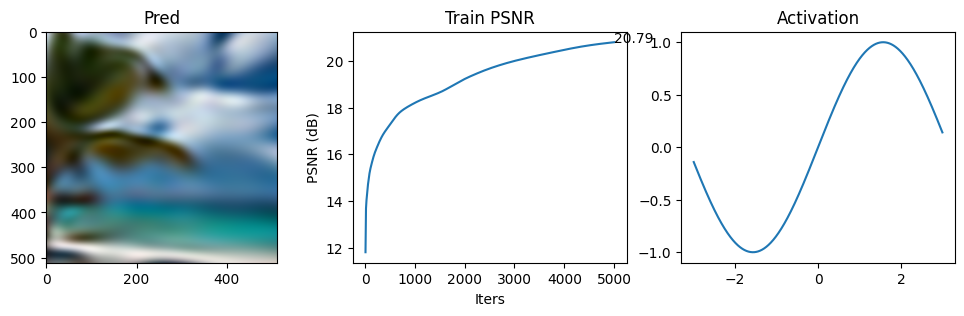

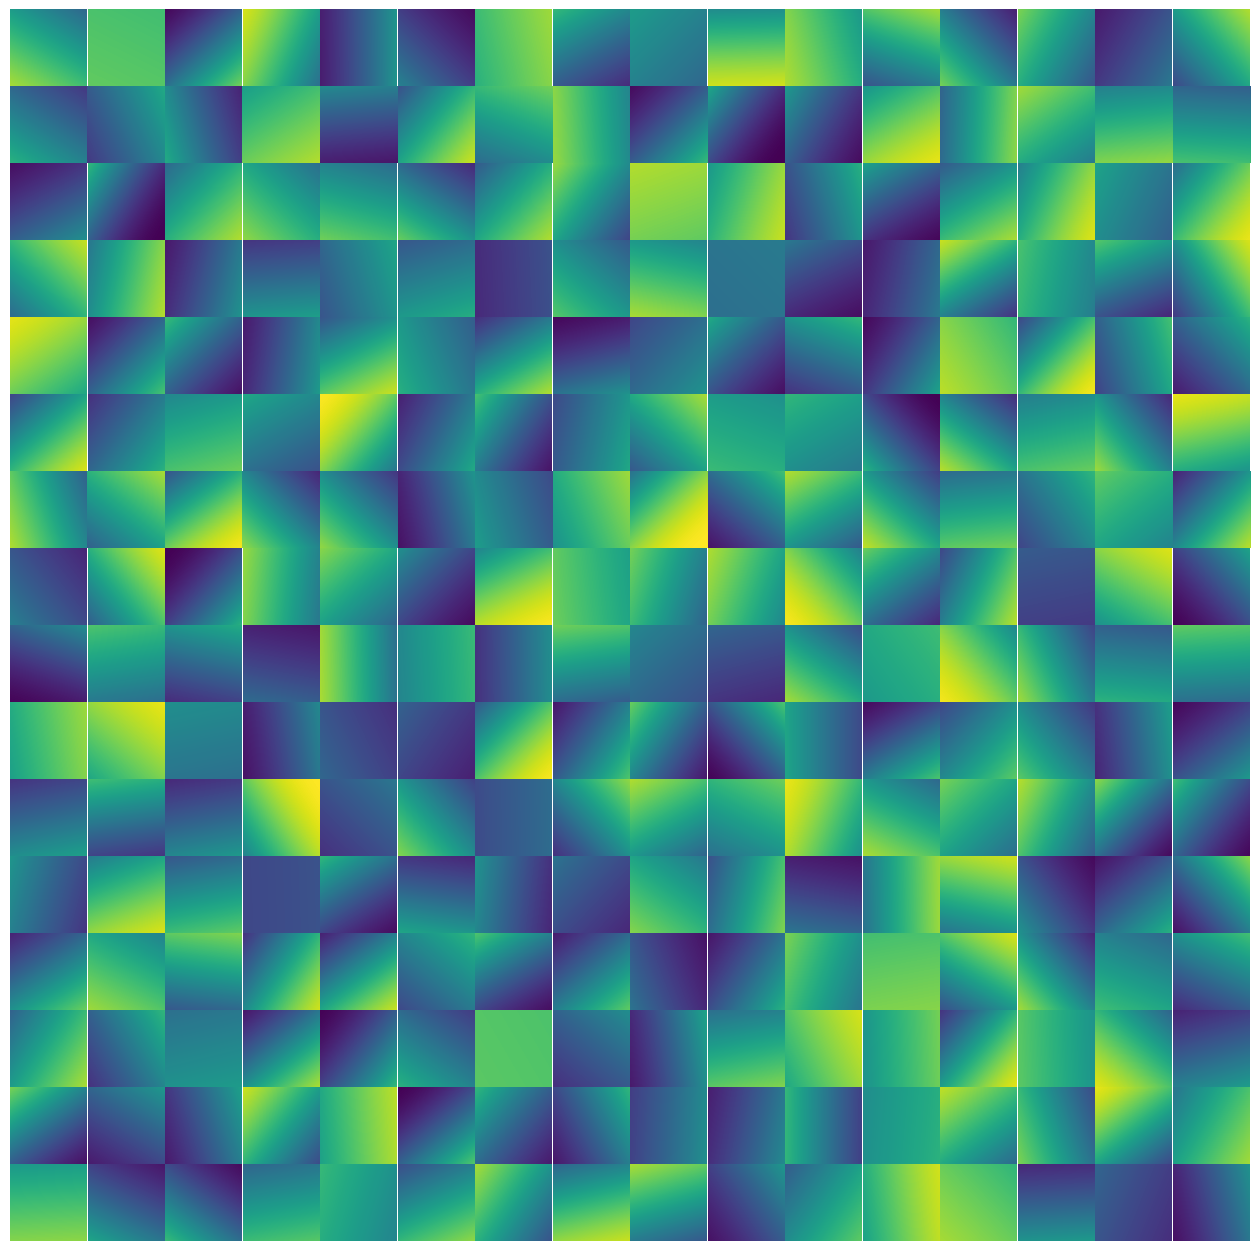

In [5]:
## SIREN
cfg = deepcopy(default_cfg)
cfg.model_type = 'Siren' 
cfg.init_method = 'sine'

# omega, Paper Sec.5.1.1
cfg.first_omega = 1
cfg.hidden_omega = 1

# net
cfg.hidden_layers = 3
cfg.hidden_features = 256

# train options
cfg.lr = 5e-4
cfg.num_epochs = 5000

# vis
cfg.vis_result = True
cfg.print_expname = True
cfg.vis_firstlayer_neuron = True

# data 
cfg.specific_img = "../div2k/test_data/07.png"

# save ckpt
cfg.logdir = f'logs/{cfg.model_type}'

## train & Plot
fitting_image_usecfg(cfg)        

imid[0]_Finer_3x256_init[sine]_fbs[20]_lr[0.0005]_fw[1]_hw[1]


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:05<00:00, 39.97it/s]


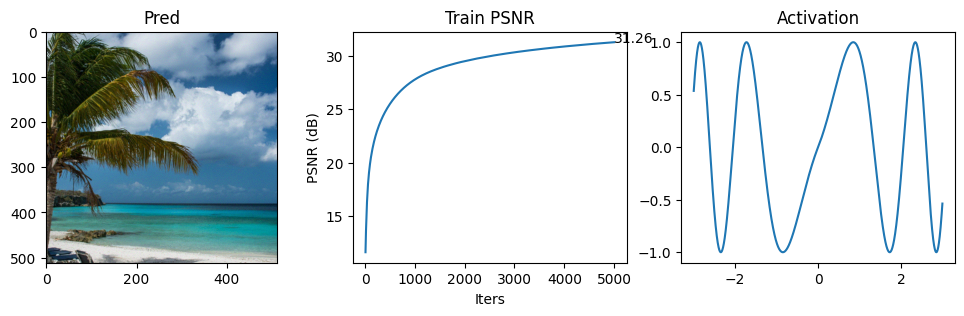

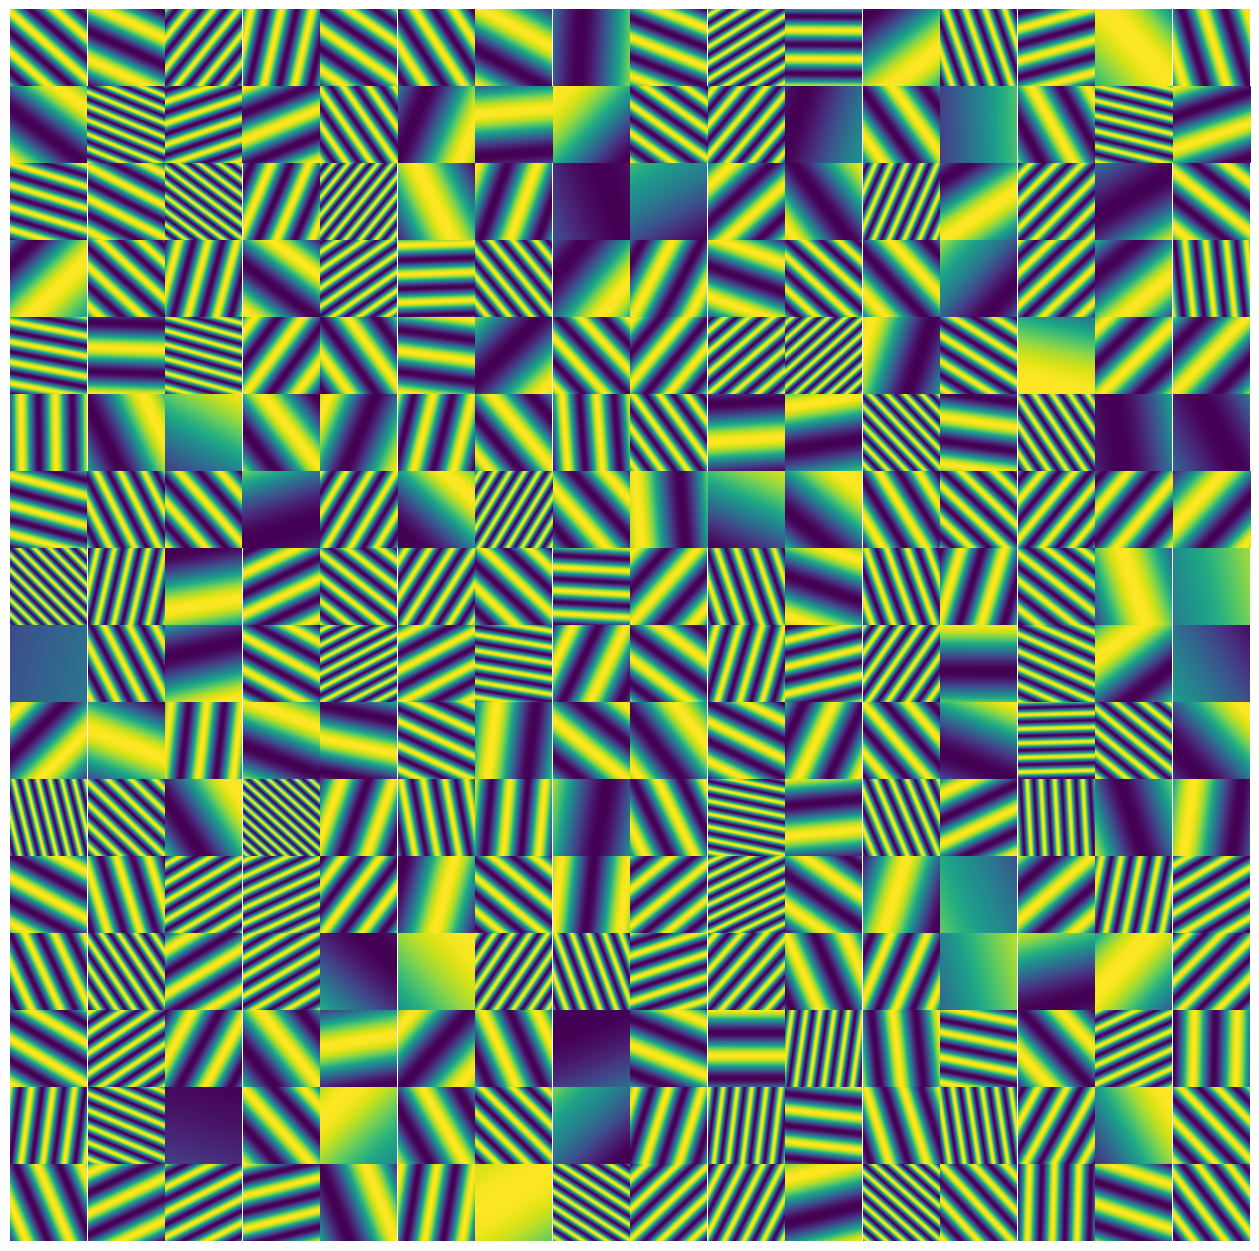

In [6]:
## FINER
cfg = deepcopy(default_cfg)
cfg.model_type = 'Finer' 

# omega
cfg.first_omega = 1
cfg.hidden_omega = 1
cfg.fbs = 20

# net
cfg.hidden_layers = 3
cfg.hidden_features = 256

# train
cfg.lr = 5e-4
cfg.num_epochs = 5000

# vis
cfg.vis_result = True
cfg.print_expname = True
cfg.vis_firstlayer_neuron = True

# data 
cfg.datadir = '../data/div2k/test_data/'

# data 
cfg.specific_img = "../div2k/test_data/07.png"

# save ckpt
cfg.logdir = f'logs/{cfg.model_type}'

## train & Plot
fitting_image_usecfg(cfg)
